# Advanced Data Manipulation

Over the next two weeks or so, we'll develop a range of skills for advanced data analysis in Python. We'll handle questions like: 

1. What if our data is split over multiple files?
2. What if our data is in the wrong shape?
3. What if our data is too big to conveniently fit in memory?  

To approach these questions, we'll develop some more advanced skills with the familiar `pandas` library. We'll also introduce new tools for plotting, including spatial plots, and take a brief look at databases. 

## Case Study: Global Warming

Throughout our study, we'll focus on a single data set. This is the Global Historical Climatology Network data set, compiled by the National Centers for Environmental Information of the US National Oceanic and Atmospheric Administration. This data set contains an extraordinarily detailed record of surface temperatures at tens of thousands of atmospheric measurement stations across the globe. It is thus an ideal, publicly available data set for studying global warming. As you know, global warming is one of the most important issues of our time, primarily because it threatens the natural habitat of nature's most majestic creature: 

<figure class="image" style="width:50%">
  <img src="http://c.files.bbci.co.uk/CF3C/production/_111925035_penguino.jpg" alt="">
  <figcaption><i></i></figcaption>
</figure>

An additional reason to be concerned about global warming is that rising temperatures reduce snowfall, a necessary prerequisite for videos of panda bears falling off of snowmen: 

<figure class="image" style="width:50%">
  <img src="https://media1.tenor.com/images/c20400089a4f275b4c1b32ebe309d93f/tenor.gif" alt="">
  <figcaption><i></i></figcaption>
</figure>

### Takeaways for Today

Here's what I want you to take away from this lecture: 

1. Many **data visualization** problems can be solved by **data manipulation**. 
2. `pandas` provides a number of handy methods for combining and reshaping your data. 
3. Pandas are very clumsy animals. 


### Data Source and Format

I accessed the data [here](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-monthly-version-4), and then did a small amount of manipulation in order to save it as a set of CSV files. The files are hosted online at 

> `https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/noaa-ghcn/decades/`

There is a file for each decade between 1901 and 2020. Today, we'll use only the file containing the most recent data, 2011-2020. 

In [1]:
import pandas as pd

# advanced plotting tools for data frames
# basically a bunch of matplotlib shortcuts
import seaborn as sns 

from matplotlib import pyplot as plt
import numpy as np

In [2]:
interval = "2011-2020"
url = f"https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/noaa-ghcn/decades/{interval}.csv"
df = pd.read_csv(url)

In [3]:
df.head(5)

,ID,Year,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,VALUE8,VALUE9,VALUE10,VALUE11,VALUE12
0,ACW00011604,2011,-83.0,-132.0,278.0,1040.0,1213.0,1663.0,1875.0,1723.0,1466.0,987.0,721.0,428.0
1,ACW00011604,2012,121.0,-98.0,592.0,646.0,1365.0,1426.0,1771.0,1748.0,1362.0,826.0,620.0,-234.0
2,ACW00011604,2013,-104.0,-93.0,-48.0,595.0,NaN,1612.0,1855.0,1802.0,1359.0,1042.0,601.0,NaN
3,AE000041196,2011,1950.0,2060.0,2280.0,2760.0,3240.0,3447.0,3580.0,3650.0,3316.0,2940.0,2390.0,1905.0
4,AE000041196,2012,1837.0,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As provided, the data set contains the following columns: 

- `ID`: the ID number of the station. We can use this to figure out which country the station is in, as well as the spatial location of the station. 
- `Year`: the year of the measurement. 
- `VALUE1`-`VALUE12`: the temperature measurements themselves. `VALUE1` contains the temperature measurements for January, `VALUE2` for February, and so on. 
- The measurements are in hundredths of a degree, Celsius. 

In [4]:
# measurement in February in very first row of DF
df["VALUE2"].iloc[0]

# temperature in degrees C is

df["VALUE2"].iloc[0] / 100

-1.32

We can now do things like plot the temperature in January for a selected station: 

<AxesSubplot:xlabel='Year', ylabel='VALUE1'>

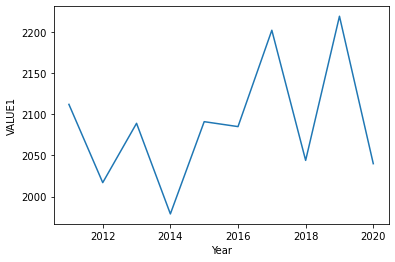

In [5]:
station_df = df[df["ID"] == "AEM00041194"]
sns.lineplot(data = station_df, x = "Year", y = "VALUE1")

At this station, the average temperature in January was typically between 20 and 22 degrees Celsius during the timeframe. 

While it can be useful to have the temperate time series, there's a lot of information missing from this plot. For example, we're only plotting for a single month of the year, and we are also only showing the observations from a single weather station. In this lecture, our goal will be to construct the following plot: 

<figure class="image" style="width:60%">
  <img src="https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/lectures/EDA/pd-1-example-plot.png" alt="">
  <figcaption><i></i></figcaption>
</figure>

This is a plot of average temperatures over time for a selection of countries (ones whose names begin with E). In order to make this plot, there are two major data manipulation operations we need to perform. We need to:  

1. Figure out what *country* each station is in. 
2. Reshape the 12 month columns into a single long column. 

These two tasks correspond to *merging* and *stacking*. These operations will come up at key points in our workflow. 

### Adding Countries with Merges

A *merge* is an operation that combines two related data frames into a single data frame, using one or more columns as *keys*. Let's take a look at how this works. The first thing we'll do is acquire a data frame that gives the full country name corresponding to the FIPS code. The FIPS code is an internationally standardized abbreviation for a country:   

In [6]:
countries_url = "https://raw.githubusercontent.com/mysociety/gaze/master/data/fips-10-4-to-iso-country-codes.csv"
countries = pd.read_csv(countries_url)
countries.head(5)

,FIPS 10-4,ISO 3166,Name
0,AF,AF,Afghanistan
1,AX,-,Akrotiri
2,AL,AL,Albania
3,AG,DZ,Algeria
4,AQ,AS,American Samoa


How can we relate this to our `df` of temperature readings? Well, it turns out that the first two characters of the `ID` column give the FIPS code! 

In [7]:
df["ID"].head(5)

0    ACW00011604
1    ACW00011604
2    ACW00011604
3    AE000041196
4    AE000041196
Name: ID, dtype: object

Let's extract them with the `str` attribute. Note that I am creating a new column whose name matches exactly the corresponding column in the `countries` data frame. 

In [8]:
df["FIPS 10-4"] = df["ID"].str[0:2]

Now it's merge time. `pandas` provides a `merge()` function with many different arguments, as well as a related `DataFrame.join()` method. There are many different ways to merge two data sets, as explained in [this helpful chapter](https://jakevdp.github.io/PythonDataScienceHandbook/03.07-merge-and-join.html) of the Python Data Science Handbook.  The default for `pd.merge` is an *inner* merge. 

In [9]:
df = pd.merge(df, countries, on = ["FIPS 10-4"])
df.head(5)

,ID,Year,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,VALUE8,VALUE9,VALUE10,VALUE11,VALUE12,FIPS 10-4,ISO 3166,Name
0,ACW00011604,2011,-83.0,-132.0,278.0,1040.0,1213.0,1663.0,1875.0,1723.0,1466.0,987.0,721.0,428.0,AC,AG,Antigua and Barbuda
1,ACW00011604,2012,121.0,-98.0,592.0,646.0,1365.0,1426.0,1771.0,1748.0,1362.0,826.0,620.0,-234.0,AC,AG,Antigua and Barbuda
2,ACW00011604,2013,-104.0,-93.0,-48.0,595.0,NaN,1612.0,1855.0,1802.0,1359.0,1042.0,601.0,NaN,AC,AG,Antigua and Barbuda
3,AE000041196,2011,1950.0,2060.0,2280.0,2760.0,3240.0,3447.0,3580.0,3650.0,3316.0,2940.0,2390.0,1905.0,AE,AE,United Arab Emirates
4,AE000041196,2012,1837.0,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE,AE,United Arab Emirates


What's happened here is the following: 

1. If the FIPS code in a row of `df` matches a FIPS code in `countries`, then the corresponding columns of `countries` are added to that row in the `merge`d result. 
2. If the FIPS code in a row of `df` is not found in `countries`, then that row is no longer present in the `merge`d result. 

Other behavior is possible. For example, one might instead prefer that, in case 2, the corresponding parts of the row are populated with `NA` values. This corresponds to a *left* join (rather than the default *inner* join). 

We now have a few unnecessary columns, so we'll remove them. 

In [10]:
df = df.drop(["FIPS 10-4", "ISO 3166"], axis = 1)

### Stacking

Recall that we are aiming to create this figure: 

<figure class="image" style="width:60%">
  <img src="https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/lectures/EDA/pd-1-example-plot.png" alt="">
  <figcaption><i></i></figcaption>
</figure>

We now know the country of each observation station, so that's good progress! But we have a bit of a problem now: we'd like to be able to plot all the months in the same time series in the logical way. We can't do this right now because each month's data is in a separate column. How can we create a single column containing the temperature observations? 

The answer is that we can *stack* these columns into a single column. `pandas` provides a convenient method for `stack`ing and `unstack`ing data: 

<figure class="image" style="width:50%">
  <img src="https://media1.tenor.com/images/c20400089a4f275b4c1b32ebe309d93f/tenor.gif" alt="">
  <figcaption><i>Pandas unstacking.</i></figcaption>
</figure>



Here's how. First, we convert all the columns that we *don't* want to stack into a multi-index for the data frame. 

In [11]:
df = df.set_index(keys=["ID", "Year", "Name"])
df.head()

VALUE1  VALUE2  VALUE3  VALUE4  VALUE5  \
ID          Year Name                                                           
ACW00011604 2011 Antigua and Barbuda    -83.0  -132.0   278.0  1040.0  1213.0   
            2012 Antigua and Barbuda    121.0   -98.0   592.0   646.0  1365.0   
            2013 Antigua and Barbuda   -104.0   -93.0   -48.0   595.0     NaN   
AE000041196 2011 United Arab Emirates  1950.0  2060.0  2280.0  2760.0  3240.0   
            2012 United Arab Emirates  1837.0  1987.0     NaN     NaN     NaN   

                                       VALUE6  VALUE7  VALUE8  VALUE9  \
ID          Year Name                                                   
ACW00011604 2011 Antigua and Barbuda   1663.0  1875.0  1723.0  1466.0   
            2012 Antigua and Barbuda   1426.0  1771.0  1748.0  1362.0   
            2013 Antigua and Barbuda   1612.0  1855.0  1802.0  1359.0   
AE000041196 2011 United Arab Emirates  3447.0  3580.0  3650.0  3316.0   
            2012 United Arab Emirates     NaN     NaN     NaN     NaN   

                                       VALUE10  VALUE11  VALUE12  
ID          Year Name                                             
ACW00011604 2011 Antigua and Barbuda     987.0    721.0    428.0  
            2012 Antigua and Barbuda     826.0    620.0   -234.0  
            2013 Antigua and Barbuda    1042.0    601.0      NaN  
AE000041196 2011 United Arab Emirates   2940.0   2390.0   1905.0  
            2012 United Arab Emirates      NaN      NaN      NaN

Then, we call the `stack()` method. This has the effect of "stacking" all of the data values on top of each other. There's also a new column indicating which of the original columns the observation came from: 

In [12]:
df = df.stack()
df

ID           Year  Name                        
ACW00011604  2011  Antigua and Barbuda  VALUE1      -83.0
                                        VALUE2     -132.0
                                        VALUE3      278.0
                                        VALUE4     1040.0
                                        VALUE5     1213.0
                                                    ...  
ZI000067983  2016  Zimbabwe             VALUE5     1692.0
                                        VALUE6     1681.0
                                        VALUE8     1828.0
                                        VALUE10    2334.0
                                        VALUE12    2287.0
Length: 1504990, dtype: float64

We can recover the `ID`, `Year`, and `Name` columns using `reset_index()`: 

In [13]:
df = df.reset_index()
df.head()

,ID,Year,Name,level_3,0
0,ACW00011604,2011,Antigua and Barbuda,VALUE1,-83.0
1,ACW00011604,2011,Antigua and Barbuda,VALUE2,-132.0
2,ACW00011604,2011,Antigua and Barbuda,VALUE3,278.0
3,ACW00011604,2011,Antigua and Barbuda,VALUE4,1040.0
4,ACW00011604,2011,Antigua and Barbuda,VALUE5,1213.0


This is looking pretty good, except that the final two columns aren't labeled very appropriately. Let's fix that up: 

In [14]:
df = df.rename(columns = {"level_3"  : "Month" , 0 : "Temperature (C)"})
df.head()

,ID,Year,Name,Month,Temperature (C)
0,ACW00011604,2011,Antigua and Barbuda,VALUE1,-83.0
1,ACW00011604,2011,Antigua and Barbuda,VALUE2,-132.0
2,ACW00011604,2011,Antigua and Barbuda,VALUE3,278.0
3,ACW00011604,2011,Antigua and Barbuda,VALUE4,1040.0
4,ACW00011604,2011,Antigua and Barbuda,VALUE5,1213.0


Better! We are now very close to our goal. The final step is to create a `datetime` column that reflects both the year and month. First, we can extract the month by picking out everything after the `"VALUE"` in the `Month` column. 

In [15]:
df["Month"] = df["Month"].str[5:].astype(int)
df.head()

,ID,Year,Name,Month,Temperature (C)
0,ACW00011604,2011,Antigua and Barbuda,1,-83.0
1,ACW00011604,2011,Antigua and Barbuda,2,-132.0
2,ACW00011604,2011,Antigua and Barbuda,3,278.0
3,ACW00011604,2011,Antigua and Barbuda,4,1040.0
4,ACW00011604,2011,Antigua and Barbuda,5,1213.0


Next, we'll create a new `datetime` column called `Date`. To do so, we can first create a string of the form `YYYY-MM`: 

In [16]:
df["Date"] = df["Year"].astype(str) + "-" + df["Month"].astype(str)
df.head()

,ID,Year,Name,Month,Temperature (C),Date
0,ACW00011604,2011,Antigua and Barbuda,1,-83.0,2011-1
1,ACW00011604,2011,Antigua and Barbuda,2,-132.0,2011-2
2,ACW00011604,2011,Antigua and Barbuda,3,278.0,2011-3
3,ACW00011604,2011,Antigua and Barbuda,4,1040.0,2011-4
4,ACW00011604,2011,Antigua and Barbuda,5,1213.0,2011-5


We can convert the result to a `DateTime` using a built-in `pandas` function. The nice thing about this function is that it can automatically detect several common formats of date-time strings. 

In [17]:
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,ID,Year,Name,Month,Temperature (C),Date
0,ACW00011604,2011,Antigua and Barbuda,1,-83.0,2011-01-01
1,ACW00011604,2011,Antigua and Barbuda,2,-132.0,2011-02-01
2,ACW00011604,2011,Antigua and Barbuda,3,278.0,2011-03-01
3,ACW00011604,2011,Antigua and Barbuda,4,1040.0,2011-04-01
4,ACW00011604,2011,Antigua and Barbuda,5,1213.0,2011-05-01


### Plotting

We are finally ready to make our plot! First, we compute the average temperature across all stations in each month, and divide by 100 to get units of degrees Celsius. 

In [18]:
averages = df.groupby(["Name", "Date"])[["Temperature (C)"]].mean()/100
averages.head()

Temperature (C)
Name        Date                       
Afghanistan 2011-01-01         5.136667
            2011-02-01         6.280000
            2011-03-01        12.643333
            2011-04-01        19.070000
            2011-05-01        26.703333

Next, we'll turn the index columns into regular columns for plotting purposes. 

In [19]:
averages = averages.reset_index()
averages.head()

,Name,Date,Temperature (C)
0,Afghanistan,2011-01-01,5.136667
1,Afghanistan,2011-02-01,6.280000
2,Afghanistan,2011-03-01,12.643333
3,Afghanistan,2011-04-01,19.070000
4,Afghanistan,2011-05-01,26.703333


Finally, we'll make the plot! To avoid overplotting, I'm going to plot only the countries whose English names begin with a given letter. The `lineplot` function of `seaborn` makes it easy to plot many labeled timeseries simultaneously. 

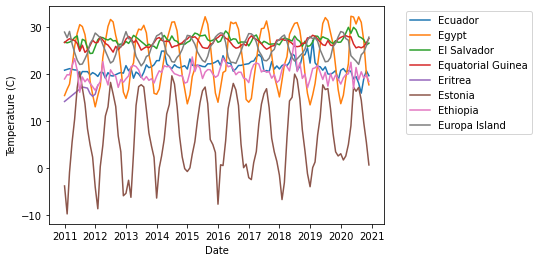

In [20]:
begins_with = averages[averages["Name"].str[0] == "E"]

sns.lineplot(data = begins_with, 
             x = "Date", 
             y = "Temperature (C)", 
             hue = "Name")

# legend needs to be adjusted
plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.savefig("pd-1-example-plot.png", bbox_inches = "tight")

We did it! Constructing this plot from the supplied data required us to *merge* and *stack* our data. This is a common pattern in applied data analysis -- we need to manipulate our data in a number of ways prior to the cool plotting or machine learning. 

### Takeaways for Today

Here's what I want you to take away from this lecture: 

1. Many **data visualization** problems can be solved by **data manipulation**. 
2. `pandas` provides a number of handy methods for combining and reshaping your data. 
3. Pandas are very clumsy animals. 